# <font color=brown>Marsland's approach on MNIST</font>
**Date:** Tuesday, April 13, 2021

## Phase 2: Experiments with Nielsen’s approach on MNIST
1.	Use Michael Nielsen’s network2.py  to train on the first 1000 samples for 100 epochs using his default values for other parameters.  Plot the evaluation accuracy and training accuracy on one plot, and the evaluation cost and training cost on another plot.
2.	Test on learning rates 0.25, 0.5, 0.7 using 3 different trials for each learning rate.  Observe and plot the performance in terms of evaluation accuracy for each learning rate.
3.	Test on mini-batches of size 5 and 20 using 3 different trials for each size and Nielsen’s default values for other parameters.  Observe adopt the performance in terms of evaluation accuracy for each mini-batch size.
4.	Train on the full 50k images for 30 epochs using the same values as Nielsen for other parameters except changing L2 parameter to 5 because of much larger training set and using the test set as the evaluation set.  Plot the evaluation accuracy and training accuracy.  Document the performance of the net.
5.	Submit your Jupyter notebook that includes the code, outputs, descriptive comments, observations and conclusions


## <font color=sienna>Introduction</font>

The MNIST or Mixed National Institute of Standards and Technology dataset is a collection of handwritten digits. The data set contains 60,000 training images and 10,000 testing images of handwriting samples. All the images are in grayscale and are 28 by 28 pixels in size. The MNIST data set is widely used in machine learning for image classification. In this project we look at two different approaches and compare them. The first is Marsland’s approach that uses MLP on MNIST and trains only 200 examples. The second approach is Nielsen’s. Nielsen’s approach trains on 1000 training examples and uses 30 hidden layer nodes, Cross-entropy, and L2 regularization. For this project however, we slightly modified the two approaches for experimental purposes. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png" width="300" align="center"/><center> **Figure 1.1:** Sample images from MNIST test dataset</center>

## <font color=sienna>Experiments</font>

The copy of Michael Nielsen’s network2.py 

In [1]:
"""network2.py
~~~~~~~~~~~~~~
An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.
"""

#### Libraries
# Standard library
import json
import random
import sys
import shelve

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt

data_file_name = 'exp_data'

#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.
        """
        return (a-y)


#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).
        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=True,
            monitor_evaluation_accuracy=True,
            monitor_training_cost=True,
            monitor_training_accuracy=True):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.
        """
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print "Epoch %s training complete" % j
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print "Cost on training data: {}".format(cost)
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print "Accuracy on training data: {} / {}".format(
                    accuracy, n)
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print "Cost on evaluation data: {}".format(cost)
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print "Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data)
            print
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.
        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.
    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.
    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [2]:
"""Loading Data"""
import mnist_loader # Loading mnist dataset. Some minor changes made to the file
import pylab as pl

training_data, validation_data, test_data = mnist_loader.load_data_wrapper() #loading train, val, test data.
training_data = list(training_data)

"""Define net with Cross entropy and 3 layers"""
net = Network([784, 30 , 10],cost=CrossEntropyCost)

In [4]:
data_file_name = 'exp_data' # Not required if network2.py was executed first

### 1.1. Train on the first 1000 samples for 100 epochs using his default values for other parameters.

In [3]:
"""Experiment: Part 1"""
evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(training_data[:1000], 100, 10, 0.5, 
        lmbda = 0.1,evaluation_data=validation_data,monitor_evaluation_accuracy=True,monitor_evaluation_cost=True,
        monitor_training_accuracy=True,monitor_training_cost=True)

print("(Note: Experiment 1 Performed!)")

"""Test Result Accumulation"""
data = shelve.open(data_file_name)
try:
    data['exp_1_epoches'] = range(0,100)
    data['exp_1_evaluation_cost'] = [x for x in evaluation_cost]
    data['exp_1_training_cost'] = [x for x in training_cost]
    data['exp_1_evaluation_accuracy'] = [x/10000.0 for x in evaluation_accuracy]
    data['exp_1_training_accuracy'] = [x/1000. for x in training_accuracy]
finally:
    data.close()

Epoch 0 training complete
Cost on training data: 1.39100611887
Accuracy on training data: 782 / 1000
Cost on evaluation data: 1.48151549384
Accuracy on evaluation data: 7542 / 10000

Epoch 1 training complete
Cost on training data: 0.848471066397
Accuracy on training data: 910 / 1000
Cost on evaluation data: 1.041107129
Accuracy on evaluation data: 8458 / 10000

Epoch 2 training complete
Cost on training data: 0.650470588359
Accuracy on training data: 936 / 1000
Cost on evaluation data: 0.899690113795
Accuracy on evaluation data: 8654 / 10000

Epoch 3 training complete
Cost on training data: 0.525454249326
Accuracy on training data: 943 / 1000
Cost on evaluation data: 0.805619976702
Accuracy on evaluation data: 8757 / 10000

Epoch 4 training complete
Cost on training data: 0.439888000241
Accuracy on training data: 960 / 1000
Cost on evaluation data: 0.7850257827
Accuracy on evaluation data: 8742 / 10000

Epoch 5 training complete
Cost on training data: 0.358924432158
Accuracy on traini

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.774674037814
Accuracy on evaluation data: 8887 / 10000

Epoch 45 training complete
Cost on training data: 0.094838578659
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.764220966867
Accuracy on evaluation data: 8911 / 10000

Epoch 46 training complete
Cost on training data: 0.0948166552127
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.776371225193
Accuracy on evaluation data: 8894 / 10000

Epoch 47 training complete
Cost on training data: 0.0943444833733
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.771253932608
Accuracy on evaluation data: 8892 / 10000

Epoch 48 training complete
Cost on training data: 0.0941766122788
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.76985207016
Accuracy on evaluation data: 8898 / 10000

Epoch 49 training complete
Cost on training data: 0.0939043556656
Accuracy on training data: 1000 / 1000
Cost on evaluation data

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786330566135
Accuracy on evaluation data: 8886 / 10000

Epoch 89 training complete
Cost on training data: 0.0906502404199
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790646021773
Accuracy on evaluation data: 8884 / 10000

Epoch 90 training complete
Cost on training data: 0.0902633831019
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.7871405624
Accuracy on evaluation data: 8882 / 10000

Epoch 91 training complete
Cost on training data: 0.0901716151874
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790987911963
Accuracy on evaluation data: 8882 / 10000

Epoch 92 training complete
Cost on training data: 0.0902256920699
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787563665758
Accuracy on evaluation data: 8883 / 10000

Epoch 93 training complete
Cost on training data: 0.0901277398969
Accuracy on training data: 1000 / 1000
Cost on evaluation data

### 1.2. Plot the evaluation accuracy and training accuracy on one plot, and the evaluation cost and training cost on another plot

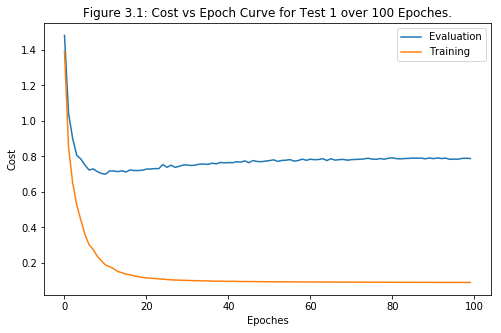

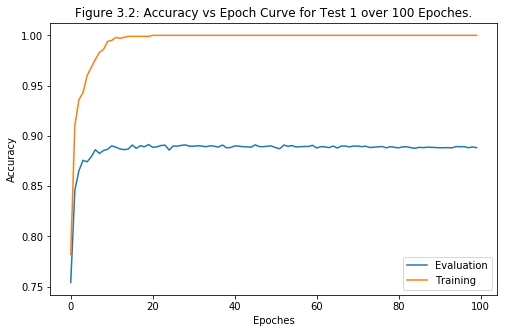

In [5]:
"""Results From Part 1 Experiments"""

data = shelve.open(data_file_name)
try:
    figureName = "Figure 3.1: Cost vs Epoch Curve for Test 1 over 100 Epoches."
    plt.figure(figsize=(8,5))
    plt.plot(data['exp_1_epoches'], data['exp_1_evaluation_cost'], label='Evaluation')
    plt.plot(data['exp_1_epoches'], data['exp_1_training_cost'], label='Training')
    plt.title(figureName)
    plt.xlabel('Epoches')
    plt.ylabel('Cost')
    plt.legend(loc='best')
    plt.show()

    figureName = "Figure 3.2: Accuracy vs Epoch Curve for Test 1 over 100 Epoches."
    plt.figure(figsize=(8,5))
    plt.plot(data['exp_1_epoches'], data['exp_1_evaluation_accuracy'], label='Evaluation')
    plt.plot(data['exp_1_epoches'], data['exp_1_training_accuracy'], label='Training')
    plt.title(figureName)
    plt.xlabel('Epoches')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()
finally:
    data.close()

Min Evaluation Cost Epoch 10 : 18.79% 
Cost on training data: 0.187957671557
Accuracy on training data: 995 / 1000
Cost on evaluation data: 0.699844652398
Accuracy on evaluation data: 8901 / 10000

Min Training Cost Epoch 99 : 8.98%
Cost on training data: 0.0898346736957
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787557422199
Accuracy on evaluation data: 8883 / 10000

Max Evaluation Accuracy Epoch 19 : 89.14% -> 0.89
Cost on training data: 0.118116794792
Accuracy on training data: 999 / 1000
Cost on evaluation data: 0.721696647455
Accuracy on evaluation data: 8914 / 10000

Max Training Accuracy Epoch 20 : 100% -> 1
Cost on training data: 0.115839324687
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.728386684838
Accuracy on evaluation data: 8886 / 10000

### 2.1. Test on learning rates 0.25, 0.5, 0.7 using 3 different trials for each learning rate.

In [6]:
"""Experiment: Part 2"""
epoch = 100
learning_rates = [0.25,0.5,0.7] 
exp_2_res_list=[]
for lr in learning_rates : 
    i=0
    print "---------Learning Rate :",lr,"------------"
    while i<3 :
        print "----Loop ",i+1,"---------"
        evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(training_data[:1000], epoch, 
                    10, lr, lmbda = 0.1,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
                    monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

        exp_2_res_list.append([lr,i+1,evaluation_accuracy])
        i = i+1

print("(Note: Experiment 2 Performed!)")

"""Result Accumulation"""
data = shelve.open(data_file_name)
try:
    data['exp_2_epoches'] = range(0,100)
    data['exp_2_test_1_learning_rates'] = [i[0] for i in exp_2_res_list if i[1]==1]
    data['exp_2_test_2_learning_rates'] = [i[0] for i in exp_2_res_list if i[1]==2]
    data['exp_2_test_3_learning_rates'] = [i[0] for i in exp_2_res_list if i[1]==3]
    data['exp_2_test_1_eval_accuracy'] = [i[2][-1]/10000.0 for i in exp_2_res_list if i[1]==1]
    data['exp_2_test_2_eval_accuracy'] = [i[2][-1]/10000.0 for i in exp_2_res_list if i[1]==2]
    data['exp_2_test_3_eval_accuracy'] = [i[2][-1]/10000.0 for i in exp_2_res_list if i[1]==3]
    data['exp_2_res_list'] = exp_2_res_list
finally:
    data.close()

---------Learning Rate : 0.25 ------------
----Loop  1 ---------
Epoch 0 training complete
Cost on training data: 0.0897328555641
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787102293292
Accuracy on evaluation data: 8886 / 10000

Epoch 1 training complete
Cost on training data: 0.0896819531585
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787222669601
Accuracy on evaluation data: 8886 / 10000

Epoch 2 training complete
Cost on training data: 0.0896687062627
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786516187288
Accuracy on evaluation data: 8886 / 10000

Epoch 3 training complete
Cost on training data: 0.0896310786115
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.791076331947
Accuracy on evaluation data: 8884 / 10000

Epoch 4 training complete
Cost on training data: 0.0896168662107
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788322117165
Accuracy on evaluation data: 8886 / 10000



Cost on evaluation data: 0.789151080746
Accuracy on evaluation data: 8881 / 10000

Epoch 44 training complete
Cost on training data: 0.0888739178574
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785658443816
Accuracy on evaluation data: 8888 / 10000

Epoch 45 training complete
Cost on training data: 0.0888203860696
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789263779478
Accuracy on evaluation data: 8883 / 10000

Epoch 46 training complete
Cost on training data: 0.0888385808899
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787355496119
Accuracy on evaluation data: 8885 / 10000

Epoch 47 training complete
Cost on training data: 0.0888924846422
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788627736566
Accuracy on evaluation data: 8890 / 10000

Epoch 48 training complete
Cost on training data: 0.0888108958263
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789189397691
Accuracy on evaluati

Cost on evaluation data: 0.788407338279
Accuracy on evaluation data: 8878 / 10000

Epoch 88 training complete
Cost on training data: 0.0881898966275
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789383966365
Accuracy on evaluation data: 8892 / 10000

Epoch 89 training complete
Cost on training data: 0.0881640561753
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789009003545
Accuracy on evaluation data: 8887 / 10000

Epoch 90 training complete
Cost on training data: 0.0881701090764
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789293494158
Accuracy on evaluation data: 8883 / 10000

Epoch 91 training complete
Cost on training data: 0.0881226113797
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786844012835
Accuracy on evaluation data: 8888 / 10000

Epoch 92 training complete
Cost on training data: 0.0881368055887
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789090765443
Accuracy on evaluati

Cost on evaluation data: 0.787247966942
Accuracy on evaluation data: 8891 / 10000

Epoch 32 training complete
Cost on training data: 0.0876349947937
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790037988115
Accuracy on evaluation data: 8886 / 10000

Epoch 33 training complete
Cost on training data: 0.0876586141993
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788498572082
Accuracy on evaluation data: 8885 / 10000

Epoch 34 training complete
Cost on training data: 0.0876213586753
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785684923741
Accuracy on evaluation data: 8894 / 10000

Epoch 35 training complete
Cost on training data: 0.0875811316693
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789315379576
Accuracy on evaluation data: 8881 / 10000

Epoch 36 training complete
Cost on training data: 0.0875979169304
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788418462118
Accuracy on evaluati

Cost on evaluation data: 0.787848075195
Accuracy on evaluation data: 8880 / 10000

Epoch 76 training complete
Cost on training data: 0.0871944555259
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784686899856
Accuracy on evaluation data: 8894 / 10000

Epoch 77 training complete
Cost on training data: 0.0871353335351
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786490525049
Accuracy on evaluation data: 8883 / 10000

Epoch 78 training complete
Cost on training data: 0.0871678378948
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78775697806
Accuracy on evaluation data: 8882 / 10000

Epoch 79 training complete
Cost on training data: 0.0871466530615
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788081222847
Accuracy on evaluation data: 8883 / 10000

Epoch 80 training complete
Cost on training data: 0.0871040517692
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787695540964
Accuracy on evaluatio

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786881956309
Accuracy on evaluation data: 8886 / 10000

Epoch 20 training complete
Cost on training data: 0.0867754355272
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788819264105
Accuracy on evaluation data: 8884 / 10000

Epoch 21 training complete
Cost on training data: 0.0867450989246
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787694128664
Accuracy on evaluation data: 8888 / 10000

Epoch 22 training complete
Cost on training data: 0.0867233530333
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786577603403
Accuracy on evaluation data: 8883 / 10000

Epoch 23 training complete
Cost on training data: 0.0867205959562
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786441987026
Accuracy on evaluation data: 8893 / 10000

Epoch 24 training complete
Cost on training data: 0.0868332315776
Accuracy on training data: 1000 / 1000
Cost on evaluation da

Cost on evaluation data: 0.78626647072
Accuracy on evaluation data: 8893 / 10000

Epoch 64 training complete
Cost on training data: 0.0864091191022
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785686956034
Accuracy on evaluation data: 8888 / 10000

Epoch 65 training complete
Cost on training data: 0.0863688063104
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785783271794
Accuracy on evaluation data: 8890 / 10000

Epoch 66 training complete
Cost on training data: 0.0863516829705
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786942401519
Accuracy on evaluation data: 8889 / 10000

Epoch 67 training complete
Cost on training data: 0.0863386212394
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786644908721
Accuracy on evaluation data: 8886 / 10000

Epoch 68 training complete
Cost on training data: 0.0863678992059
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783466068456
Accuracy on evaluatio

Cost on evaluation data: 0.787642010705
Accuracy on evaluation data: 8878 / 10000

Epoch 8 training complete
Cost on training data: 0.0861021783007
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790760626861
Accuracy on evaluation data: 8873 / 10000

Epoch 9 training complete
Cost on training data: 0.0861451899915
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784804531466
Accuracy on evaluation data: 8880 / 10000

Epoch 10 training complete
Cost on training data: 0.0859956243161
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784609495484
Accuracy on evaluation data: 8897 / 10000

Epoch 11 training complete
Cost on training data: 0.0860490077111
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786801873568
Accuracy on evaluation data: 8884 / 10000

Epoch 12 training complete
Cost on training data: 0.0861193411633
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783251797795
Accuracy on evaluation

Cost on evaluation data: 0.788779866667
Accuracy on evaluation data: 8885 / 10000

Epoch 52 training complete
Cost on training data: 0.0853723690088
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786580442165
Accuracy on evaluation data: 8889 / 10000

Epoch 53 training complete
Cost on training data: 0.0853639901329
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786277017988
Accuracy on evaluation data: 8896 / 10000

Epoch 54 training complete
Cost on training data: 0.0854242682439
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.793040068209
Accuracy on evaluation data: 8876 / 10000

Epoch 55 training complete
Cost on training data: 0.0853667924588
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786623986133
Accuracy on evaluation data: 8888 / 10000

Epoch 56 training complete
Cost on training data: 0.0854119707339
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784504655229
Accuracy on evaluati

Cost on evaluation data: 0.78492195019
Accuracy on evaluation data: 8894 / 10000

Epoch 96 training complete
Cost on training data: 0.0852359188942
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.793894908182
Accuracy on evaluation data: 8871 / 10000

Epoch 97 training complete
Cost on training data: 0.0848893835542
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78800248718
Accuracy on evaluation data: 8872 / 10000

Epoch 98 training complete
Cost on training data: 0.0848307762829
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789334865328
Accuracy on evaluation data: 8878 / 10000

Epoch 99 training complete
Cost on training data: 0.0848525904724
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786909928293
Accuracy on evaluation data: 8897 / 10000

----Loop  2 ---------
Epoch 0 training complete
Cost on training data: 0.0848084651172
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785051589932
A

Cost on evaluation data: 0.787364856448
Accuracy on evaluation data: 8888 / 10000

Epoch 40 training complete
Cost on training data: 0.0844101792832
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784310740737
Accuracy on evaluation data: 8887 / 10000

Epoch 41 training complete
Cost on training data: 0.084381671879
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786552402151
Accuracy on evaluation data: 8887 / 10000

Epoch 42 training complete
Cost on training data: 0.0844822425454
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784961510522
Accuracy on evaluation data: 8900 / 10000

Epoch 43 training complete
Cost on training data: 0.0845011971779
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782587015272
Accuracy on evaluation data: 8896 / 10000

Epoch 44 training complete
Cost on training data: 0.0844755381878
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785111522657
Accuracy on evaluatio

Cost on evaluation data: 0.786267331501
Accuracy on evaluation data: 8899 / 10000

Epoch 84 training complete
Cost on training data: 0.084068259534
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783428714401
Accuracy on evaluation data: 8891 / 10000

Epoch 85 training complete
Cost on training data: 0.084135951052
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783187742385
Accuracy on evaluation data: 8891 / 10000

Epoch 86 training complete
Cost on training data: 0.0839440214326
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788149755741
Accuracy on evaluation data: 8888 / 10000

Epoch 87 training complete
Cost on training data: 0.0841095975139
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786103226859
Accuracy on evaluation data: 8889 / 10000

Epoch 88 training complete
Cost on training data: 0.0840719991618
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786730265147
Accuracy on evaluation

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782026920714
Accuracy on evaluation data: 8893 / 10000

Epoch 28 training complete
Cost on training data: 0.0837248680452
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779818642341
Accuracy on evaluation data: 8890 / 10000

Epoch 29 training complete
Cost on training data: 0.0837149263692
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78273619711
Accuracy on evaluation data: 8889 / 10000

Epoch 30 training complete
Cost on training data: 0.0838246710884
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784652122228
Accuracy on evaluation data: 8899 / 10000

Epoch 31 training complete
Cost on training data: 0.083758832625
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787489168544
Accuracy on evaluation data: 8886 / 10000

Epoch 32 training complete
Cost on training data: 0.083695652433
Accuracy on training data: 1000 / 1000
Cost on evaluation data:

Cost on training data: 0.0834163655882
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781492157182
Accuracy on evaluation data: 8893 / 10000

Epoch 72 training complete
Cost on training data: 0.0835289712945
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785198607668
Accuracy on evaluation data: 8889 / 10000

Epoch 73 training complete
Cost on training data: 0.0836745173914
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.791349699576
Accuracy on evaluation data: 8881 / 10000

Epoch 74 training complete
Cost on training data: 0.0833860695071
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782513506497
Accuracy on evaluation data: 8888 / 10000

Epoch 75 training complete
Cost on training data: 0.0835269516197
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783703395835
Accuracy on evaluation data: 8894 / 10000

Epoch 76 training complete
Cost on training data: 0.0834349537203
Accuracy on training 

Cost on evaluation data: 0.784142567305
Accuracy on evaluation data: 8893 / 10000

Epoch 15 training complete
Cost on training data: 0.0833609636345
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779805387067
Accuracy on evaluation data: 8887 / 10000

Epoch 16 training complete
Cost on training data: 0.083104131274
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78682073577
Accuracy on evaluation data: 8887 / 10000

Epoch 17 training complete
Cost on training data: 0.0833157349204
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.7801444467
Accuracy on evaluation data: 8901 / 10000

Epoch 18 training complete
Cost on training data: 0.0832516852859
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784861964684
Accuracy on evaluation data: 8881 / 10000

Epoch 19 training complete
Cost on training data: 0.0832124289074
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780515464727
Accuracy on evaluation d

Cost on evaluation data: 0.785676870217
Accuracy on evaluation data: 8885 / 10000

Epoch 59 training complete
Cost on training data: 0.0829880950427
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781411244279
Accuracy on evaluation data: 8889 / 10000

Epoch 60 training complete
Cost on training data: 0.0831473523273
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783578523691
Accuracy on evaluation data: 8901 / 10000

Epoch 61 training complete
Cost on training data: 0.0829080461148
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.788502672966
Accuracy on evaluation data: 8888 / 10000

Epoch 62 training complete
Cost on training data: 0.0828593828905
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784003875356
Accuracy on evaluation data: 8893 / 10000

Epoch 63 training complete
Cost on training data: 0.0829215585352
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780369815041
Accuracy on evaluati

Cost on evaluation data: 0.783073362898
Accuracy on evaluation data: 8887 / 10000

Epoch 3 training complete
Cost on training data: 0.082434495295
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781235795562
Accuracy on evaluation data: 8887 / 10000

Epoch 4 training complete
Cost on training data: 0.0825259952651
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784022452584
Accuracy on evaluation data: 8900 / 10000

Epoch 5 training complete
Cost on training data: 0.0825722330935
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78400621604
Accuracy on evaluation data: 8891 / 10000

Epoch 6 training complete
Cost on training data: 0.0827421060095
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786832726308
Accuracy on evaluation data: 8873 / 10000

Epoch 7 training complete
Cost on training data: 0.08249941534
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784920252325
Accuracy on evaluation data: 

Cost on evaluation data: 0.785396524944
Accuracy on evaluation data: 8889 / 10000

Epoch 47 training complete
Cost on training data: 0.0823436272756
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780735019185
Accuracy on evaluation data: 8895 / 10000

Epoch 48 training complete
Cost on training data: 0.0824026911386
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787438134789
Accuracy on evaluation data: 8883 / 10000

Epoch 49 training complete
Cost on training data: 0.0822461418304
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782871802867
Accuracy on evaluation data: 8893 / 10000

Epoch 50 training complete
Cost on training data: 0.0822369169171
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784079898508
Accuracy on evaluation data: 8887 / 10000

Epoch 51 training complete
Cost on training data: 0.082376857791
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789661900827
Accuracy on evaluatio

Cost on evaluation data: 0.787726866216
Accuracy on evaluation data: 8875 / 10000

Epoch 91 training complete
Cost on training data: 0.0819007432345
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781810875085
Accuracy on evaluation data: 8892 / 10000

Epoch 92 training complete
Cost on training data: 0.0819335585633
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782352114244
Accuracy on evaluation data: 8883 / 10000

Epoch 93 training complete
Cost on training data: 0.0821439676987
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.7876074939
Accuracy on evaluation data: 8887 / 10000

Epoch 94 training complete
Cost on training data: 0.0821672857911
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786853429179
Accuracy on evaluation data: 8877 / 10000

Epoch 95 training complete
Cost on training data: 0.082053310688
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790873506138
Accuracy on evaluation 

Cost on evaluation data: 0.785422459147
Accuracy on evaluation data: 8884 / 10000

Epoch 35 training complete
Cost on training data: 0.0818942752251
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787231012639
Accuracy on evaluation data: 8893 / 10000

Epoch 36 training complete
Cost on training data: 0.0816823446076
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785296429947
Accuracy on evaluation data: 8879 / 10000

Epoch 37 training complete
Cost on training data: 0.0818847695802
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.785187095652
Accuracy on evaluation data: 8886 / 10000

Epoch 38 training complete
Cost on training data: 0.0816595720642
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789965789561
Accuracy on evaluation data: 8883 / 10000

Epoch 39 training complete
Cost on training data: 0.0818593533721
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782097540536
Accuracy on evaluati

Cost on evaluation data: 0.779972788746
Accuracy on evaluation data: 8890 / 10000

Epoch 79 training complete
Cost on training data: 0.0814947640753
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783121710032
Accuracy on evaluation data: 8886 / 10000

Epoch 80 training complete
Cost on training data: 0.0815916871918
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787470365907
Accuracy on evaluation data: 8886 / 10000

Epoch 81 training complete
Cost on training data: 0.0815739655819
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787065800585
Accuracy on evaluation data: 8887 / 10000

Epoch 82 training complete
Cost on training data: 0.0816915243037
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782050249015
Accuracy on evaluation data: 8900 / 10000

Epoch 83 training complete
Cost on training data: 0.0814836854286
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786465466504
Accuracy on evaluati

### 2.2. Observe and plot the performance in terms of evaluation accuracy for each learning rate.


Test 1 : learning rates [0.25, 0.5, 0.7] , Evaluation Accuracy [0.8884, 0.8897, 0.8885]
Test 2 : learning rates [0.25, 0.5, 0.7] , Evaluation Accuracy [0.889, 0.8906, 0.8891]
Test 3 : learning rates [0.25, 0.5, 0.7] , Evaluation Accuracy [0.889, 0.8896, 0.8888]


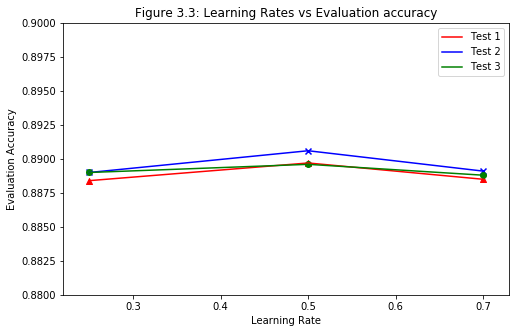

In [7]:
"""Results From Part 2 Experiments"""
data = shelve.open(data_file_name)
try:
    print 
    print "Test 1 : learning rates",data['exp_2_test_1_learning_rates'],", Evaluation Accuracy",data['exp_2_test_1_eval_accuracy']
    print "Test 2 : learning rates",data['exp_2_test_2_learning_rates'],", Evaluation Accuracy", data['exp_2_test_2_eval_accuracy']
    print "Test 3 : learning rates",data['exp_2_test_3_learning_rates'],", Evaluation Accuracy", data['exp_2_test_3_eval_accuracy']
    figureName = "Figure 3.3: Learning Rates vs 100th epoch Evaluation accuracy"
    plt.figure(figsize=(8,5))
    plt.scatter(data['exp_2_test_1_learning_rates'],  data['exp_2_test_1_eval_accuracy'],color='red' ,marker = '^')
    plt.plot(data['exp_2_test_1_learning_rates'], data['exp_2_test_1_eval_accuracy'],color='red',label=str('Test 1'))
   
    plt.scatter(data['exp_2_test_2_learning_rates'], data['exp_2_test_2_eval_accuracy'],color='blue' ,marker = 'x')
    plt.plot(data['exp_2_test_2_learning_rates'], data['exp_2_test_2_eval_accuracy'],color='blue',label=str('Test 2'))
   
    plt.scatter(data['exp_2_test_3_learning_rates'], data['exp_2_test_3_eval_accuracy'],color='green',marker = 'o')
    plt.plot(data['exp_2_test_3_learning_rates'], data['exp_2_test_3_eval_accuracy'],color='green',label=str('Test 3'))
   
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([0.88,0.90])
    plt.title(figureName)
    plt.xlabel('Learning Rate')
    plt.ylabel('Evaluation Accuracy')
    plt.legend(loc='best')
    plt.show()
finally:
    data.close()

#### Max Evaluation Accuracy 

The accuracy varied among individual epoches but was almost consistent throughout ranging between 88.95%-89.10%. The best accuracy was for learning rate 0.7 with 89.10%. There wasn't a significant difference with the change in learning rate.

For learning rate 0.25

Test 1 : Epoch 79 Cost on training data: 0.088407459694 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.78736028613 Accuracy on evaluation data: 8897 / 10000

Test 2 : Epoch 67 Cost on training data: 0.0872564386367 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.786081734897 Accuracy on evaluation data: 8895 / 10000

Test 3 : Epoch 98 Cost on training data: 0.0861482812036 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.786817066286 Accuracy on evaluation data: 8897 / 10000

For learning rate 0.5

Test 1 : Epoch 56 Cost on training data: 0.0854119707339 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.784504655229 Accuracy on evaluation data: 8910 / 10000

Test 2 : Epoch 46 Cost on training data: 0.0846435121285 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.784699264208 Accuracy on evaluation data: 8908 / 10000

Test 3 : Epoch 40 Cost on training data: 0.0836692265152 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.777918313703 Accuracy on evaluation data: 8907 / 10000

For learning rate 0.7

Test 1 : Epoch 48 Cost on training data: 0.0830364517493 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.776500117537 Accuracy on evaluation data: 8908 / 10000

Test 2 : Epoch 28 Cost on training data: 0.0827193434588 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.775547951186 Accuracy on evaluation data: 8910 / 10000

Test 3 : Epoch 23 Cost on training data: 0.0819855759689 Accuracy on training data: 1000 / 1000 Cost on evaluation data: 0.783979675921 Accuracy on evaluation data: 8909 / 10000 

### 3.1. Test on mini-batches of size 5 and 20 using 3 different trials for each size and Nielsen’s default values for other parameters.

In [8]:
"""Experiment: Part 3"""
epoch = 100
minibatch = [5,20] 
exp_3_res_list=[]
for mb in minibatch : 
    i=0
    print "---------Mini Batch : ",mb,"------------"
    while i<3 :
        print "----Loop ",i+1,"---------"
        evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(
            training_data[:1000], epoch, mb, 0.5, lmbda = 0.1,evaluation_data=validation_data,monitor_evaluation_accuracy=
            True, monitor_evaluation_cost=True, monitor_training_accuracy=True,monitor_training_cost=True)

        exp_3_res_list.append([mb,i+1,evaluation_accuracy])
        i = i+1

print("(Note: Experiment 3 Performed!)")

"""Result Accumulation"""
data = shelve.open(data_file_name)
try:
    data['exp_3_epoches'] = range(0,100)
    data['exp_3_test_1_mini_batch_sizes'] = [i[0] for i in exp_3_res_list if i[1]==1]
    data['exp_3_test_2_mini_batch_sizes'] = [i[0] for i in exp_3_res_list if i[1]==2]
    data['exp_3_test_3_mini_batch_sizes'] = [i[0] for i in exp_3_res_list if i[1]==3]
    data['exp_3_test_1_eval_accuracy'] = [i[2][-1]/10000.0 for i in exp_3_res_list if i[1]==1]
    data['exp_3_test_2_eval_accuracy'] = [i[2][-1]/10000.0 for i in exp_3_res_list if i[1]==2]
    data['exp_3_test_3_eval_accuracy'] = [i[2][-1]/10000.0 for i in exp_3_res_list if i[1]==3]
    data['exp_3_res_list'] = exp_3_res_list
finally:
    data.close()

---------Mini Batch :  5 ------------
----Loop  1 ---------
Epoch 0 training complete
Cost on training data: 0.0819153348376
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780232119264
Accuracy on evaluation data: 8884 / 10000

Epoch 1 training complete
Cost on training data: 0.0818144789022
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789974895475
Accuracy on evaluation data: 8893 / 10000

Epoch 2 training complete
Cost on training data: 0.0817713998918
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786464535258
Accuracy on evaluation data: 8891 / 10000

Epoch 3 training complete
Cost on training data: 0.081903496129
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787772381104
Accuracy on evaluation data: 8893 / 10000

Epoch 4 training complete
Cost on training data: 0.0816137754866
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.77848921552
Accuracy on evaluation data: 8895 / 10000

Epoch 5

Cost on evaluation data: 0.788430619744
Accuracy on evaluation data: 8886 / 10000

Epoch 44 training complete
Cost on training data: 0.0814644454266
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784500497975
Accuracy on evaluation data: 8899 / 10000

Epoch 45 training complete
Cost on training data: 0.0814377371435
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.778683054038
Accuracy on evaluation data: 8895 / 10000

Epoch 46 training complete
Cost on training data: 0.0813457748186
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.777881723173
Accuracy on evaluation data: 8900 / 10000

Epoch 47 training complete
Cost on training data: 0.0813953109553
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786435606149
Accuracy on evaluation data: 8877 / 10000

Epoch 48 training complete
Cost on training data: 0.0814002532943
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779783745394
Accuracy on evaluati

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784332213433
Accuracy on evaluation data: 8886 / 10000

Epoch 88 training complete
Cost on training data: 0.0813175737422
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.776548208748
Accuracy on evaluation data: 8897 / 10000

Epoch 89 training complete
Cost on training data: 0.0810859204624
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784359601627
Accuracy on evaluation data: 8895 / 10000

Epoch 90 training complete
Cost on training data: 0.0817216216429
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.789943271173
Accuracy on evaluation data: 8884 / 10000

Epoch 91 training complete
Cost on training data: 0.0810578674729
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.776677611915
Accuracy on evaluation data: 8884 / 10000

Epoch 92 training complete
Cost on training data: 0.0812980547464
Accuracy on training data: 1000 / 1000
Cost on evaluation da

Cost on evaluation data: 0.7797789977
Accuracy on evaluation data: 8891 / 10000

Epoch 32 training complete
Cost on training data: 0.0813744432485
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784459784766
Accuracy on evaluation data: 8888 / 10000

Epoch 33 training complete
Cost on training data: 0.0809807422673
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.778021534276
Accuracy on evaluation data: 8901 / 10000

Epoch 34 training complete
Cost on training data: 0.0809426622779
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786223240628
Accuracy on evaluation data: 8880 / 10000

Epoch 35 training complete
Cost on training data: 0.08092865031
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780474782661
Accuracy on evaluation data: 8884 / 10000

Epoch 36 training complete
Cost on training data: 0.0808905811959
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.786913079993
Accuracy on evaluation d

Cost on evaluation data: 0.785691323869
Accuracy on evaluation data: 8889 / 10000

Epoch 76 training complete
Cost on training data: 0.0808825789743
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.791570251428
Accuracy on evaluation data: 8883 / 10000

Epoch 77 training complete
Cost on training data: 0.081169893418
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.776898089533
Accuracy on evaluation data: 8888 / 10000

Epoch 78 training complete
Cost on training data: 0.080908448725
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780822519996
Accuracy on evaluation data: 8906 / 10000

Epoch 79 training complete
Cost on training data: 0.0810856693902
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.792411357193
Accuracy on evaluation data: 8880 / 10000

Epoch 80 training complete
Cost on training data: 0.0810180153096
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784390323272
Accuracy on evaluation

Cost on evaluation data: 0.784602655348
Accuracy on evaluation data: 8889 / 10000

Epoch 20 training complete
Cost on training data: 0.081307650993
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.787882526458
Accuracy on evaluation data: 8888 / 10000

Epoch 21 training complete
Cost on training data: 0.0805232079516
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781222936877
Accuracy on evaluation data: 8894 / 10000

Epoch 22 training complete
Cost on training data: 0.080779115397
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.77581778538
Accuracy on evaluation data: 8910 / 10000

Epoch 23 training complete
Cost on training data: 0.0808622802034
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790831753356
Accuracy on evaluation data: 8882 / 10000

Epoch 24 training complete
Cost on training data: 0.0807794652215
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783547698675
Accuracy on evaluation 

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.776787473033
Accuracy on evaluation data: 8897 / 10000

Epoch 64 training complete
Cost on training data: 0.0808528407325
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.790309698782
Accuracy on evaluation data: 8870 / 10000

Epoch 65 training complete
Cost on training data: 0.0809001236743
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.792688028986
Accuracy on evaluation data: 8862 / 10000

Epoch 66 training complete
Cost on training data: 0.08058582903
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780321658579
Accuracy on evaluation data: 8893 / 10000

Epoch 67 training complete
Cost on training data: 0.0805289440948
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783401571898
Accuracy on evaluation data: 8884 / 10000

Epoch 68 training complete
Cost on training data: 0.0804221673089
Accuracy on training data: 1000 / 1000
Cost on evaluation data

Accuracy on evaluation data: 8889 / 10000

Epoch 7 training complete
Cost on training data: 0.0800758788175
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781977728971
Accuracy on evaluation data: 8889 / 10000

Epoch 8 training complete
Cost on training data: 0.0800783858089
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78365190332
Accuracy on evaluation data: 8894 / 10000

Epoch 9 training complete
Cost on training data: 0.0800879307064
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.784271873985
Accuracy on evaluation data: 8888 / 10000

Epoch 10 training complete
Cost on training data: 0.0800965868955
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779965871181
Accuracy on evaluation data: 8890 / 10000

Epoch 11 training complete
Cost on training data: 0.0800753946758
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.783967004549
Accuracy on evaluation data: 8892 / 10000

Epoch 12 training com

Cost on evaluation data: 0.782107092741
Accuracy on evaluation data: 8888 / 10000

Epoch 51 training complete
Cost on training data: 0.0800015927805
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782838129507
Accuracy on evaluation data: 8882 / 10000

Epoch 52 training complete
Cost on training data: 0.0800779798382
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780490063399
Accuracy on evaluation data: 8896 / 10000

Epoch 53 training complete
Cost on training data: 0.080014046425
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779917957891
Accuracy on evaluation data: 8889 / 10000

Epoch 54 training complete
Cost on training data: 0.079992227249
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781327337319
Accuracy on evaluation data: 8884 / 10000

Epoch 55 training complete
Cost on training data: 0.0800080192431
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780579679341
Accuracy on evaluation

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781728789584
Accuracy on evaluation data: 8887 / 10000

Epoch 95 training complete
Cost on training data: 0.0799515008344
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780673861629
Accuracy on evaluation data: 8885 / 10000

Epoch 96 training complete
Cost on training data: 0.0799442139248
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780428185606
Accuracy on evaluation data: 8889 / 10000

Epoch 97 training complete
Cost on training data: 0.0799703221202
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781811244066
Accuracy on evaluation data: 8888 / 10000

Epoch 98 training complete
Cost on training data: 0.0799603678298
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782239544054
Accuracy on evaluation data: 8891 / 10000

Epoch 99 training complete
Cost on training data: 0.0799674797452
Accuracy on training data: 1000 / 1000
Cost on evaluation da

Cost on evaluation data: 0.778618889115
Accuracy on evaluation data: 8887 / 10000

Epoch 39 training complete
Cost on training data: 0.0799531237463
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.778623744322
Accuracy on evaluation data: 8888 / 10000

Epoch 40 training complete
Cost on training data: 0.0799515586283
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779954267872
Accuracy on evaluation data: 8883 / 10000

Epoch 41 training complete
Cost on training data: 0.0799436319659
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782617915656
Accuracy on evaluation data: 8884 / 10000

Epoch 42 training complete
Cost on training data: 0.0799724717224
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781878100866
Accuracy on evaluation data: 8890 / 10000

Epoch 43 training complete
Cost on training data: 0.0799575404202
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781781389216
Accuracy on evaluati

Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781236342465
Accuracy on evaluation data: 8890 / 10000

Epoch 83 training complete
Cost on training data: 0.0798982770639
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780145208034
Accuracy on evaluation data: 8890 / 10000

Epoch 84 training complete
Cost on training data: 0.0799716757504
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.782365183999
Accuracy on evaluation data: 8888 / 10000

Epoch 85 training complete
Cost on training data: 0.0799042650702
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780166521811
Accuracy on evaluation data: 8887 / 10000

Epoch 86 training complete
Cost on training data: 0.079927263612
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780369258927
Accuracy on evaluation data: 8887 / 10000

Epoch 87 training complete
Cost on training data: 0.0799350511728
Accuracy on training data: 1000 / 1000
Cost on evaluation dat

Cost on training data: 0.0798786353584
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780676573525
Accuracy on evaluation data: 8890 / 10000

Epoch 27 training complete
Cost on training data: 0.0798745799627
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781510693444
Accuracy on evaluation data: 8889 / 10000

Epoch 28 training complete
Cost on training data: 0.0798911979413
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.78133292272
Accuracy on evaluation data: 8884 / 10000

Epoch 29 training complete
Cost on training data: 0.0798663941147
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780448286403
Accuracy on evaluation data: 8883 / 10000

Epoch 30 training complete
Cost on training data: 0.0798912345623
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779460155329
Accuracy on evaluation data: 8886 / 10000

Epoch 31 training complete
Cost on training data: 0.0798667090822
Accuracy on training d

Accuracy on evaluation data: 8884 / 10000

Epoch 70 training complete
Cost on training data: 0.0798645301623
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.781636498462
Accuracy on evaluation data: 8887 / 10000

Epoch 71 training complete
Cost on training data: 0.0798932636889
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780638799642
Accuracy on evaluation data: 8882 / 10000

Epoch 72 training complete
Cost on training data: 0.079860004179
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780008846479
Accuracy on evaluation data: 8883 / 10000

Epoch 73 training complete
Cost on training data: 0.0798619329188
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.779951861894
Accuracy on evaluation data: 8893 / 10000

Epoch 74 training complete
Cost on training data: 0.0798802528469
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.780380509908
Accuracy on evaluation data: 8885 / 10000

Epoch 75 training 

### 3.2. Observe adopt the performance in terms of evaluation accuracy for each mini-batch size.


Test 1 : Mini Batch [5, 20] , Evaluation Accuracy [0.8878, 0.8891]
Test 2 : Mini Batch [5, 20] , Evaluation Accuracy [0.8888, 0.8889]
Test 3 : Mini Batch [5, 20] , Evaluation Accuracy [0.8879, 0.8887]


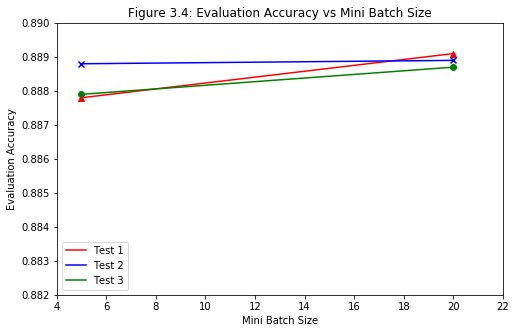

In [12]:
"""Results From Part 3 Experiments"""
data = shelve.open(data_file_name)
try:
    print 
    print "Test 1 : Mini Batch",data['exp_3_test_1_mini_batch_sizes'],", Evaluation Accuracy",data['exp_3_test_1_eval_accuracy']
    print "Test 2 : Mini Batch",data['exp_3_test_2_mini_batch_sizes'],", Evaluation Accuracy", data['exp_3_test_2_eval_accuracy']
    print "Test 3 : Mini Batch",data['exp_3_test_3_mini_batch_sizes'],", Evaluation Accuracy", data['exp_3_test_3_eval_accuracy']
    
    figureName = "Figure 3.4: Evaluation Accuracy vs Mini Batch Size"
    plt.figure(figsize=(8,5))
    plt.scatter(data['exp_3_test_1_mini_batch_sizes'], data['exp_3_test_1_eval_accuracy'],color='red' ,marker = '^')
    plt.plot(data['exp_3_test_1_mini_batch_sizes'], data['exp_3_test_1_eval_accuracy'],color='red',label=str('Test 1'))
    
    plt.scatter(data['exp_3_test_2_mini_batch_sizes'], data['exp_3_test_2_eval_accuracy'],color='blue' ,marker = 'x')
    plt.plot(data['exp_3_test_2_mini_batch_sizes'], data['exp_3_test_2_eval_accuracy'],color='blue',label=str('Test 2'))
    
    plt.scatter(data['exp_3_test_3_mini_batch_sizes'], data['exp_3_test_3_eval_accuracy'],color='green',marker = 'o')
    plt.plot(data['exp_3_test_3_mini_batch_sizes'], data['exp_3_test_3_eval_accuracy'],color='green',label=str('Test 3'))

    axes = plt.gca()
    axes.set_xlim([4,22])
    axes.set_ylim([0.882,0.89])
    plt.title(figureName)
    plt.xlabel('Mini Batch Size')
    plt.ylabel('Evaluation Accuracy')
    plt.legend(loc='best')
    plt.show()
finally:
    data.close()

#### Max Evaluation Accuracy

Evaluation Accuracy increases with the increase in mini batch size for the last epoch shown above in the plot. Looking at the values of all the epoches from above, we can see that with the increase in mini batch size, the accuracy converges and becomes more consistent. Here in the plot, when mini batch size is 5 the accuracy ranges from 88.78%-88.88% but for mini batch size 20, it ranges from 88.87%-88.91%.

### 4.1. Train on the full 50k images for 30 epochs using the same values as Nielsen for other parameters except changing L2 parameter to 5 because of much larger training set. 

In [13]:
"""Experiment: Part 4"""
evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(training_data, 30, 10, 0.5, lmbda = 5.0,
        evaluation_data=validation_data,monitor_evaluation_accuracy=True,monitor_evaluation_cost=True,
        monitor_training_accuracy=True,monitor_training_cost=True)

print("(Note: Experiment 4 Performed!)")

"""Result Accumulation"""
data = shelve.open(data_file_name)
try:
    data['exp_4_epoches'] = range(0,30)
    data['exp_4_evaluation_accuracy'] = [x/10000.0 for x in evaluation_accuracy]
    data['exp_4_training_accuracy'] = [x/50000.0 for x in training_accuracy]
finally:
    data.close()

Epoch 0 training complete
Cost on training data: 0.462471635515
Accuracy on training data: 47329 / 50000
Cost on evaluation data: 0.825635170457
Accuracy on evaluation data: 9464 / 10000

Epoch 1 training complete
Cost on training data: 0.435570758618
Accuracy on training data: 47668 / 50000
Cost on evaluation data: 0.869364316381
Accuracy on evaluation data: 9517 / 10000

Epoch 2 training complete
Cost on training data: 0.41653386773
Accuracy on training data: 47860 / 50000
Cost on evaluation data: 0.889221615169
Accuracy on evaluation data: 9547 / 10000

Epoch 3 training complete
Cost on training data: 0.416786424472
Accuracy on training data: 47870 / 50000
Cost on evaluation data: 0.914585423759
Accuracy on evaluation data: 9534 / 10000

Epoch 4 training complete
Cost on training data: 0.383909622872
Accuracy on training data: 48192 / 50000
Cost on evaluation data: 0.897723136201
Accuracy on evaluation data: 9608 / 10000

Epoch 5 training complete
Cost on training data: 0.4243589884

### 4.2. Plot the evaluation accuracy and training accuracy. 

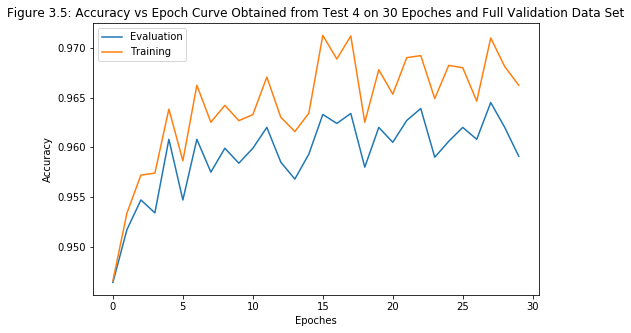

In [14]:
"""Results From Part 4 Experiments"""
data = shelve.open(data_file_name)
try:
    figureName = "Figure 3.5: Accuracy vs Epoch Curve Obtained from Test 4 on 30 Epoches and Full Data Set"
    plt.figure(figsize=(8,5))
    plt.plot(data['exp_4_epoches'], data['exp_4_evaluation_accuracy'], label='Evaluation')
    plt.plot(data['exp_4_epoches'], data['exp_4_training_accuracy'], label='Training')
    plt.title(figureName)
    plt.xlabel('Epoches')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()
finally:
    data.close()

Max Accuracy is for training data set in comparison to evaluation data set.

## <font color=sienna>Conclusion</font>

Both approaches have merit and provide insight into training the nets for the dataset. The advantage of the Marsland approach is that there is a larger focus on number of nodes than any other parameter which would help optimize the net for number of nodes quite well. The disadvantage is that multiple epochs are not used and learning rate is not as important as number of nodes. The advantage to using Nielsen’s approach is that the focus lies more on learning rates, batch size, and epochs with the highest emphasis being placed on learning rate and epochs. If both were to be used in tandem the focus on number of nodes could be used from the Marsland approach with a learning rate of 0.5 which was determined to be the best from the Nielsen approach. After the number of nodes was adjusted for the 0.5 learning rate the epoch and mini batch parameters could be retested and the best results could be used from the combination of the two approaches. This setup would result in the most accurate classification process and produce less error while also decreasing the number of iterations necessary to get learning rates or epochs from using either approach alone. 